# Info


Here I will develop the simple densely connect model which will serve as a baseline. The idea is to create a model that can train in about 10 minutes and that provides with a reasonable baseline for more complex models.

# Version v1.0

TODO:

- napravit vector embedding sensor_id-a prema koordinatama sensora, a ne prema embed_dim. Tako ćeš imat samo 3 koordinate. Možeš svim tim vektorima oduzet centar mase. Pitanje: je li neutrino u datasetu nužno prolazi kroz ishodište?
- hendlat vrijeme kao kumulativnu varijablu? "time (int): the time of the pulse in nanoseconds in the current event time window. The absolute time of a pulse has no relevance, and only the relative time with respect to other pulses within an event is of relevance."
- na kraju ti je dimenzija input vektora (B, T, 3 + 1 + 1), 3 za lokaciju senzora (xyz), jedan za naboj i jedan za kumulativno vrijeme (koliko je vremena prošlo od početka). Možda možeš dodat još i jednu dimenziju, a to je auxiliary, dakle to bi bilo (B, T, 6)
- It's very important to remove the center of mass from the points to correctly estimate the angles!


In [96]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import wandb
import gc

In [97]:

LOG_WANDB = True
# hyperparameters
n_opt_distance=3000000 # number of optimizations for distance loss
n_opt_angular=0 # number of optimizations for angular loss
max_iters = n_opt_distance + n_opt_angular # number of iterations
change_data_each = 10 # change batch of data every change_batch_every steps
device =   'cuda' if torch.cuda.is_available() else 'cpu'
evaluate_every_step = 1024
eval_iters = 32 # number of batches to process for evaluation

grad_clip = False # enable gradient clipping
grad_clip_val = 1e-8 # gradient clipping value

## network hyperparameters
batch_size= 512
gradient_accumulation_steps = 512 // batch_size # 256 // batch_size # used to simulate larger batch sizes
learning_rate = 1e-6 * batch_size / gradient_accumulation_steps
block_size = 96 # maximum context length
n_embd = 128
n_layers = 3
num_heads = 8
dropout = 0.2
ffwd_scale = 4
# --------------------
## 
num_bins = 64

print_each = 100
print_model_each = 10000

torch.manual_seed(1337);

# Load sensor geometry

In [98]:
df_sensor_geometry = pd.read_csv("../../sensor_geometry.csv")
sensor_ids = sorted(list(set(df_sensor_geometry["sensor_id"].to_list())))
sensor_ids[:10], len(sensor_ids)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 5160)

In [99]:
# list train files in "/home/ubuntu/neutrino/high-speed/data/train" and test in "/home/ubuntu/neutrino/high-speed/data/test"
train_files = !ls /home/ubuntu/neutrino/high-speed/data/train
test_files = !ls /home/ubuntu/neutrino/high-speed/data/test

In [100]:
# add root path to train and test files
train_files = ["/home/ubuntu/neutrino/high-speed/data/train/" + f for f in train_files]
test_files = ["/home/ubuntu/neutrino/high-speed/data/test/" + f for f in test_files]

In [101]:
df = pd.read_parquet(test_files[0]).fillna(0)

In [102]:
df

,x_1,y_1,z_1,t_1,charge_1,charge_clipped_1,auxiliary_1,has_event_1,x_2,y_2,...,x_96,y_96,z_96,t_96,charge_96,charge_clipped_96,auxiliary_96,has_event_96,azimuth,zenith
0,-0.49130,-0.38098,0.45830,0.414312,0.4125,0,1,1,0.02374,0.35838,...,0.00000,0.00000,0.00000,0.000000,0.0000,0,0,0,1.455179,1.385139
1,0.72200,-0.84566,0.45436,0.375875,0.3875,0,1,1,0.60682,0.67128,...,0.00000,0.00000,0.00000,0.000000,0.0000,0,0,0,1.182545,1.073292
2,0.10852,0.58594,-0.21042,0.370937,0.8125,0,1,1,0.10852,0.58594,...,0.00000,0.00000,0.00000,0.000000,0.0000,0,0,0,4.812856,2.279083
3,-0.13340,0.55384,-0.74046,0.370250,0.5875,0,1,1,-0.66960,-0.84900,...,0.00000,0.00000,0.00000,0.000000,0.0000,0,0,0,5.207917,0.722861
4,0.06250,-0.14586,-0.45844,0.388062,0.5875,0,1,1,0.06250,-0.14586,...,0.00000,0.00000,0.00000,0.000000,0.0000,0,0,0,3.723178,2.829807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,-0.46990,0.28088,-0.36154,0.369437,0.3625,0,1,1,0.11440,-0.21104,...,0.00000,0.00000,0.00000,0.000000,0.0000,0,0,0,6.198101,2.676218
2720,0.66006,0.25440,-0.70034,0.376000,0.5375,0,1,1,0.31788,-0.69046,...,0.39006,0.25118,-0.49416,1.134937,0.4375,0,1,1,2.774357,0.124723
2721,-0.31246,0.08674,-0.53020,0.370937,0.3125,0,1,1,-0.46990,0.28088,...,-0.37996,0.51484,0.08358,1.063562,0.5375,0,1,1,2.008464,0.902644
2722,0.26406,0.40596,-0.45832,0.370250,0.5125,0,1,1,-0.02194,0.01344,...,0.00000,0.00000,0.00000,0.000000,0.0000,0,0,0,0.012985,1.496544


In [103]:
x = df.values
len(x), x

(2724,
 array([[-0.4913    , -0.38098   ,  0.4583    , ...,  0.        ,
          1.45517938,  1.38513897],
        [ 0.722     , -0.84566   ,  0.45436   , ...,  0.        ,
          1.18254459,  1.07329169],
        [ 0.10852   ,  0.58594   , -0.21042   , ...,  0.        ,
          4.81285553,  2.27908285],
        ...,
        [-0.31246   ,  0.08674   , -0.5302    , ...,  1.        ,
          2.00846445,  0.90264441],
        [ 0.26406   ,  0.40596   , -0.45832   , ...,  0.        ,
          0.01298527,  1.49654403],
        [-0.4699    ,  0.28088   ,  0.52354   , ...,  0.        ,
          5.51859887,  1.37537228]]))

In [104]:
x2 = np.array(x[0])
y = x2[-2:]
x2 = x2[:-2]

In [105]:
np.reshape(x2, (96, 8))[:,:3].shape

(96, 3)

In [106]:
df=df.iloc[0]

In [107]:
# def get_el():
#     x = df.iloc[0].values
#     x = np.array(x[:-2])
#     x = np.reshape(x, (len(x)//8, 8))
#     x = np.array(x, dtype=np.float32)
#     x[np.isnan(x)] = 0
#     return x
    
# # %timeit get_el()
# # 353 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

In [108]:
# x = get_el()

In [109]:
class EventDataLoader:
    def __init__(self):
        self.change_data_each = change_data_each
        self.data_files = {
            'train': train_files,
            'test': test_files,
        }
        self.events = {
            'train': pd.read_parquet(train_files[0]).fillna(0).values,
            'test': pd.read_parquet(test_files[0]).fillna(0).values,
        }
        # self.remove_nans('train')
        # self.remove_nans('test')
        self.batch_size = batch_size
        
        
        self.counter=0 # used to keep track of the current batch
    
    def refresh_batch(self):
        self.counter = 0
        random_file_train = random.choice(self.data_files['train'])
        random_file_test = random.choice(self.data_files['test'])
        self.events = {
            'train': pd.read_parquet(random_file_train).fillna(0).values,
            # 'test': pd.read_parquet(random_file_test).fillna(0).values,
        }
        # self.remove_nans('train')
        # self.remove_nans('test')
    
    # def remove_nans(self, split):
    #     # convert nan to zero
    #     self.events[split] = self.events[split].fillna(0)
        
    def get_random_el(self, split):
        randint = random.randint(0, len(self.events[split])-1)
        x = self.events[split][randint]
        y = np.array(x[-2:], dtype=np.float32)
        x = np.array(x[:-2])
        x = np.reshape(x, (96, 8))
        x = np.array(x, dtype=np.float32)
        # x_1	y_1	z_1	t_1	charge_1	charge_clipped_1	auxiliary_1	has_event_1
        xyz = x[:,:3]
        # xyz_avg is xyz subtracted by the center of mass along each axis. use keepdims=True to keep the shape
        t = x[:,3]
        charge = x[:,4]
        charge_clipped = x[:,5]
        auxiliary = x[:,6]
        has_event = x[:,7]
        xyz_avg = xyz - np.mean(xyz, axis=0, keepdims=True)
        xyz_avg[np.where(has_event<0.5)] = 0
        
        x = {
            'xyz': xyz,
            'xyz_avg': xyz_avg,
            't': t,
            'charge': charge,
            'charge_clipped': charge_clipped,
            'auxiliary': auxiliary,
            'has_event': has_event
        }
        
        return x, y

    
    def get_xy(self, split):
        
        
        preprocessed_data = [self.get_random_el(split) for _ in range(self.batch_size)]
        
        xyz_avg_batch = torch.stack([torch.from_numpy(x['xyz_avg']) for x, _ in preprocessed_data])
        xyz_batch = torch.stack([torch.from_numpy(x['xyz']) for x, _ in preprocessed_data])
        time_batch = torch.stack([torch.from_numpy(x['t']) for x, _ in preprocessed_data])
        charge_batch = torch.stack([torch.from_numpy(x['charge']) for x, _ in preprocessed_data])
        charge_clipped_batch = torch.stack([torch.from_numpy(x['charge_clipped']) for x, _ in preprocessed_data])
        auxiliary_batch = torch.stack([torch.from_numpy(x['auxiliary']) for x, _ in preprocessed_data])
        has_event_batch = torch.stack([torch.from_numpy(x['has_event']) for x, _ in preprocessed_data])
        y = torch.stack([torch.from_numpy(y) for _, y in preprocessed_data])
        
        # send to device
        xyz_avg_batch = xyz_avg_batch.to(device)
        xyz_batch = xyz_batch.to(device)
        time_batch = time_batch.to(device)
        charge_batch = charge_batch.to(device)
        charge_clipped_batch = charge_clipped_batch.to(device)
        auxiliary_batch = auxiliary_batch.to(device)
        has_event_batch = has_event_batch.to(device)
        y = y.to(device)
        
        
        
        X = {
            "xyz_avg": xyz_avg_batch,
            "xyz": xyz_batch,
            "time": time_batch,
            "charge": charge_batch,
            "charge_clipped": charge_clipped_batch,
            "auxiliary": auxiliary_batch,
            "has_event": has_event_batch,
        }
        
        self.counter += 1
        if self.counter == self.change_data_each:
            self.refresh_batch()
            self.counter = 0
        
        return X, y


In [110]:
data_loader = EventDataLoader()

In [111]:
X, y = data_loader.get_xy('train')

In [112]:
X['xyz_avg'].shape

torch.Size([64, 96, 3])

In [113]:
X.keys()

dict_keys(['xyz_avg', 'xyz', 'time', 'charge', 'charge_clipped', 'auxiliary', 'has_event'])

In [114]:
# 1 in angles
1*np.pi/180

0.017453292519943295

In [115]:
y[:,0]

tensor([2.8887, 0.7663, 2.9211, 1.9787, 3.0344, 4.7348, 3.8046, 5.2838, 4.6686,
        1.1296, 1.7708, 2.9311, 3.1145, 4.9343, 1.6188, 1.5712, 6.1546, 6.0089,
        2.7829, 0.3744, 4.8138, 4.5212, 3.3586, 6.2285, 4.3045, 3.2437, 2.5533,
        0.7459, 0.9430, 5.1522, 4.7174, 5.1731, 2.6123, 2.6555, 4.6598, 3.8697,
        4.7560, 2.7514, 4.1510, 3.7210, 5.7034, 2.1410, 4.0169, 2.6019, 1.5396,
        0.1706, 5.3853, 3.2267, 4.8758, 6.1277, 0.3114, 2.0254, 4.8009, 1.2611,
        1.9178, 0.9220, 6.2379, 2.2223, 0.7368, 0.0727, 3.0151, 5.5387, 2.9159,
        4.7885], device='cuda:0')

In [116]:
X['xyz_avg'][0]

tensor([[ 0.4617,  0.0026,  0.8669],
        [-0.5542,  0.5393,  0.4866],
        [-0.4393, -0.9777, -0.9875],
        [ 0.4617,  0.0026, -0.1203],
        [ 0.0967,  0.4228, -0.6685],
        [ 1.2257,  0.4063,  0.6085],
        [ 0.2540,  0.2291, -0.0571],
        [ 0.4219,  0.6955, -0.8519],
        [ 0.2869,  0.1186, -0.6330],
        [-0.3281, -0.0836,  0.8375],
        [-0.3281, -0.0836,  0.8375],
        [-0.3281, -0.0836,  0.8034],
        [-0.3281, -0.0836,  0.8034],
        [-0.3281, -0.0836,  0.8715],
        [-0.3281, -0.0836,  0.7694],
        [-0.3969,  0.3453,  0.7908],
        [ 0.7499,  0.9919,  0.2574],
        [-0.4183, -0.3166,  0.4532],
        [-0.7539, -0.5901,  0.2452],
        [-0.7539, -0.5901,  0.2452],
        [-0.5758, -0.1224, -0.5708],
        [-0.7539, -0.5901,  0.1430],
        [-0.7539, -0.5901,  0.1430],
        [-0.7539, -0.5901,  0.1090],
        [-0.7539, -0.5901,  0.1430],
        [-0.7539, -0.5901,  0.3132],
        [ 0.2540,  0.2291,  0.5557],
 

# Angular Loss function

In [117]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (torch.all(torch.isfinite(az_true))  and
            torch.all(torch.isfinite(zen_true)) and
            torch.all(torch.isfinite(az_pred)) and
            torch.all(torch.isfinite(zen_pred))
           ):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = torch.sin(az_true)
    ca1 = torch.cos(az_true)
    sz1 = torch.sin(zen_true)
    cz1 = torch.cos(zen_true)
    
    sa2 = torch.sin(az_pred)
    ca2 = torch.cos(az_pred)
    sz2 = torch.sin(zen_pred)
    cz2 = torch.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  torch.clamp(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)

    return torch.abs(torch.acos(scalar_prod))

In [118]:
# estimates the loss over eval_iters batches.
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'test']:
        losses_distance = []
        losses_angular = []
        for k in range(eval_iters):
            X, y = data_loader.get_xy(split)
            (x, loss), (theta, phi, loss_angular) = model(X, y)
            losses_distance.append(loss.detach().cpu().numpy())
            losses_angular.append(loss_angular.detach().cpu().numpy())
        out[split] = {}
        out[split]['distance'] = np.average(losses_distance)
        out[split]['angular'] = np.average(losses_angular)
    model.train()
    return out

# Model

In [165]:
class ResidualLSTM(nn.Module):
    
    def __init__(self, d_model):
        super(ResidualLSTM, self).__init__()
        self.LSTM=nn.LSTM(d_model, d_model, num_layers=1, bidirectional=True)
        self.linear1=nn.Linear(d_model*2, d_model*4)
        self.linear2=nn.Linear(d_model*4, d_model)
        

            
    def forward(self, x):
        res=x
        x, _ = self.LSTM(x)
        x=F.relu(self.linear1(x))
        x=self.linear2(x)
        x=res+x
        return x
    
    
class SAKTModel(nn.Module):
    
    
    
    def _init_weights(self, module):
        
        init_std = 0.05
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=init_std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    
    def __init__(self, nout, n_embd=128,  nlayers=2, rnnlayers=3,
    dropout=0.1, nheads=8):
        super(SAKTModel, self).__init__()
        self.n_embd = n_embd
        self.pos_encoder = nn.ModuleList([ResidualLSTM(n_embd) for i in range(rnnlayers)])
        
        self.pos_encoder_dropout = nn.Dropout(dropout)
        
        self.embedding = nn.Linear(11, n_embd)
        self.layer_normal = nn.LayerNorm(n_embd)
        encoder_layers = [nn.TransformerEncoderLayer(n_embd, nheads, n_embd*4, dropout) for i in range(nlayers)]
        conv_layers = [nn.Conv1d(n_embd,n_embd,(nlayers-i)*2-1,stride=1,padding=0) for i in range(nlayers)]
        deconv_layers = [nn.ConvTranspose1d(n_embd,n_embd,(nlayers-i)*2-1,stride=1,padding=0) for i in range(nlayers)]
        layer_norm_layers = [nn.LayerNorm(n_embd) for i in range(nlayers)]
        layer_norm_layers2 = [nn.LayerNorm(n_embd) for i in range(nlayers)]
        self.transformer_encoder = nn.ModuleList(encoder_layers)
        self.conv_layers = nn.ModuleList(conv_layers)
        self.layer_norm_layers = nn.ModuleList(layer_norm_layers)
        self.layer_norm_layers2 = nn.ModuleList(layer_norm_layers2)
        self.deconv_layers = nn.ModuleList(deconv_layers)
        self.nheads = nheads
        self.pred = nn.Linear(n_embd, nout)

        self.apply(self._init_weights)
            

    def forward(self, numerical_features):
        B, T, C = numerical_features.shape
        x=self.embedding(numerical_features.view(B*T, C)).view(B, T, self.n_embd)
        
        x = x.permute(1, 0, 2)
        for lstm in self.pos_encoder:
            lstm.LSTM.flatten_parameters()
            x=lstm(x)

        x = self.pos_encoder_dropout(x)
        x = self.layer_normal(x)



        for conv, transformer_layer, layer_norm1, layer_norm2, deconv in zip(self.conv_layers,
                                                               self.transformer_encoder,
                                                               self.layer_norm_layers,
                                                               self.layer_norm_layers2,
                                                               self.deconv_layers):
            #LXBXC to BXCXL
            res=x
            x=F.relu(conv(x.permute(1,2,0)).permute(2,0,1))
            x=layer_norm1(x)
            x=transformer_layer(x)
            x=F.relu(deconv(x.permute(1,2,0)).permute(2,0,1))
            x=layer_norm2(x)
            x=res+x

        x = x.permute(1, 0, 2)

        output = self.pred(x)
        output = output.squeeze(-1)
        
        # (B, T, C) -> (B, C)
        output = output[:, -1, :]
        output = F.softmax(output, dim=1)
        return output

In [166]:
class NeutrinoDetection(nn.Module):
    def __init__(self):
        super(NeutrinoDetection, self).__init__()
        self.model_theta = SAKTModel(nout=num_bins, n_embd=n_embd,  nlayers=2, rnnlayers=3, dropout=dropout, nheads=num_heads).to(device)
        self.model_phi = SAKTModel(nout=num_bins, n_embd=n_embd,  nlayers=2, rnnlayers=3, dropout=dropout, nheads=num_heads).to(device)
        
        
        

    def forward(self, X, targets=None):
        
        xyz_avg, xyz, time, charge, charge_clipped, auxiliary, has_event = X["xyz_avg"], X["xyz"], X["time"], X["charge"], X["charge_clipped"], X["auxiliary"], X["has_event"]
        
        x = torch.cat([xyz_avg, xyz, time.unsqueeze(-1), charge.unsqueeze(-1), charge_clipped.unsqueeze(-1), auxiliary.unsqueeze(-1), has_event.unsqueeze(-1)], dim=-1)
        
        theta_probas = self.model_theta(x)
        phi_probas = self.model_phi(x)
        
        
        theta_pred = np.pi * torch.argmax(theta_probas, dim=1) / num_bins # (B)
        phi_pred = 2 * np.pi * torch.argmax(phi_probas, dim=1) / num_bins # (B)
        
        # define the bin edges for the ordinal labels
        # bin_edges = torch.linspace(0, 1, num_bins+1)[1:-1].to(device)
        
        # cumprods_theta = torch.cumprod(theta_probas > 0.5, dim=1)
        # theta_pred = (torch.sum(cumprods_theta, dim=1) - 1) * np.pi / num_bins # (B)
        # cumprods_phi = torch.cumprod(phi_probas > 0.5, dim=1)
        # phi_pred = (torch.sum(cumprods_phi, dim=1) - 1) * 2*np.pi / num_bins # (B)
        
        if targets is None:
            loss = None
            loss_angular = None
        else: 
            # Get the angle theta and phi from the 3D vector
            phi_target = targets[:, 0]
            theta_target = targets[:, 1]
            
            
            
            losses_angular = angular_dist_score(phi_target, theta_target, phi_pred, theta_pred)
            # losses_angular = angular_dist_score(phi_target, theta_target, phi, theta)
            # loss_angular = torch.sum(event_size * losses_angular) / torch.sum(event_size)
            loss_angular = torch.mean(losses_angular)
            
            
            
            
            # construct the phi_target_probability and theta_target_probability: these are one-hot vectors with the same shape as phi_probas and theta_probas, with 1 at the position of 
            theta_target = theta_target / np.pi
            theta_target = theta_target * num_bins
            theta_target = theta_target.long()
            theta_target = torch.nn.functional.one_hot(theta_target, num_classes=num_bins)
            
            phi_target = phi_target / (2*np.pi)
            phi_target = phi_target * num_bins
            phi_target = phi_target.long()
            phi_target = torch.nn.functional.one_hot(phi_target, num_classes=num_bins)
            
            

            # loss is sum of the cross entropy of the predicted probabilities and the target probabilities
            eps = 1e-8
            loss_theta = torch.mean(-torch.sum(torch.log(theta_probas+eps)*theta_target, axis=-1))
            loss_phi = torch.mean(-torch.sum(torch.log(phi_probas+eps)*phi_target, axis=-1))
            loss = loss_theta + loss_phi
            
            

            # # construct the theta_target_probability and phi_target_probability as ordinal targets
            # theta_target_bins = torch.bucketize(theta_target, bin_edges).to(device)
            # theta_target_probability = torch.zeros((len(theta_target), num_bins), dtype=torch.float32)
            # for i, bin_idx in enumerate(theta_target_bins):
            #     theta_target_probability[i, :bin_idx] = 1

            # phi_target_bins = torch.bucketize(phi_target, bin_edges).to(device)
            # phi_target_probability = torch.zeros((len(phi_target), num_bins), dtype=torch.float32)
            # for i, bin_idx in enumerate(phi_target_bins):
            #     phi_target_probability[i, :bin_idx] = 1

            # # send to device
            # theta_target_probability = theta_target_probability.to(device)
            # phi_target_probability = phi_target_probability.to(device)
            
            # # compute the ordinal loss
            # eps = 1e-8
            # loss_theta = torch.mean(-torch.sum(torch.log(torch.cat((theta_probas, 1-theta_probas), dim=-1)+eps) * torch.cat((theta_target_probability, 1-theta_target_probability), dim=-1), axis=-1))
            # loss_phi = torch.mean(-torch.sum(torch.log(torch.cat((phi_probas, 1-phi_probas), dim=-1)+eps) * torch.cat((phi_target_probability, 1-phi_target_probability), dim=-1), axis=-1))
            # loss = loss_theta + loss_phi


            
            
            
        
        return (x, loss), (theta_pred, phi_pred, loss_angular)
        

In [167]:
model = NeutrinoDetection()

# load /home/ubuntu/neutrino/high-speed/m11-lstm/model-best-96b.pth
model.load_state_dict(torch.load('model-best-96b.pth'), strict=False)
model = model.to(device)


print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

3.912832 M parameters


In [ ]:
# # freeze all layers except those that contain "pred." in the name
# for name, param in model.named_parameters():
#     if "pred" not in name:
#         param.requires_grad = False

In [163]:
# X, y = data_loader.get_xy('train')
# x = model(X)

In [123]:
# class Head(nn.Module):
#     """ one head of self-attention """

#     def __init__(self, n_embd, head_size, dropout):
#         super().__init__()
#         self.key = nn.Linear(n_embd, head_size, bias=False)
#         self.query = nn.Linear(n_embd, head_size, bias=False)
#         self.value = nn.Linear(n_embd, head_size, bias=False)

#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         # input of size (batch, time-step, channels)
#         # output of size (batch, time-step, head size)
#         B,T,C = x.shape
#         k = self.key(x)   # (B,T,hs)
#         q = self.query(x) # (B,T,hs)
#         # compute attention scores ("affinities")
#         self.wei = q @ k.transpose(-2,-1) * (k.shape[-1] / math.sqrt(k.shape[-2])) # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        
#         self.wei = F.softmax(self.wei, dim=-1) # (B, T, T)
#         self.wei = self.dropout(self.wei)
#         # perform the weighted aggregation of the values
#         v = self.value(x) # (B,T,hs)
#         self.out = self.wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
#         return self.out

# class MultiHeadAttention(nn.Module):
#     """ multiple heads of self-attention in parallel """

#     def __init__(self, num_heads, n_embd, head_size, dropout):
#         super().__init__()
#         self.heads = nn.ModuleList([Head(n_embd, head_size, dropout) for _ in range(num_heads)])
#         self.proj = nn.Linear(head_size * num_heads, n_embd)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         self.out = torch.cat([h(x) for h in self.heads], dim=-1)
#         self.out = self.dropout(self.proj(self.out))
#         return self.out

# class FeedForward(nn.Module):
#     """ a simple linear layer followed by a non-linearity """

#     def __init__(self, n_embd, dropout):
#         super().__init__()
        
#         super().__init__()
#         self.c_fc    = nn.Linear(n_embd, ffwd_scale * n_embd)
#         self.c_proj  = nn.Linear(ffwd_scale * n_embd, n_embd)
#         self.dropout = nn.Dropout(dropout)
        
        
#     def forward(self, x):
#         x = self.c_fc(x)
#         x = nn.ReLU()(x)
#         x = self.c_proj(x)
#         self.out = self.dropout(x)
#         return self.out

# class Block(nn.Module):
#     """ Transformer block: communication followed by computation """

#     def __init__(self, num_heads, n_embd, dropout):
#         # n_embd: embedding dimension, num_heads: the number of heads we'd like
#         super().__init__()
#         head_size = n_embd // num_heads
#         self.sa = MultiHeadAttention(num_heads, n_embd, head_size, dropout)
#         self.ffwd = FeedForward(n_embd, dropout)
#         self.ln1 = nn.LayerNorm(n_embd)
#         self.ln2 = nn.LayerNorm(n_embd)

#     def forward(self, x):
#         x = x + self.sa(self.ln1(x))
#         self.out = x + self.ffwd(self.ln2(x))
#         return self.out
    
    
    
# class FeatureExtractor(nn.Module):
#     """ input (B,T,C), output (B, C) """
#     def __init__(self, n_embd, num_heads, n_layers, dropout=0.2):
#         super().__init__()
        
#         self.net = nn.Sequential(*[Block(num_heads, n_embd, dropout) for _ in range(n_layers)])
        
#     def forward(self, x):
#         x = self.net(x) # (B, T, C)
#         self.out = x[:, -1, :] # (B, C)
#         return self.out
 
 
    
    
# class TransformerModel(nn.Module):

#     def _init_weights(self, module):
        
#         init_std = 0.005
        
#         if isinstance(module, nn.Linear):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=init_std)
#             if module.bias is not None:
#                 torch.nn.init.zeros_(module.bias)
#         elif isinstance(module, nn.Embedding):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=2*init_std)
            
#     def __init__(self, n_embd, num_heads, n_layers, dropout=0.2):
#         super().__init__()
        
#         self.n_embd = n_embd
#         self.feat_emb = nn.Linear(11, n_embd)
#         self.positional_embeddings = nn.Embedding(block_size, n_embd)
        
#         # feature extractor
#         self.features_extractor = FeatureExtractor(2*n_embd, num_heads, n_layers, dropout)
        
#         # get probabilities for theta and phi
#         self.theta_probas_layer = nn.Linear(2*n_embd, num_bins)
#         self.phi_probas_layer = nn.Linear(2*n_embd, num_bins)
        
        
#         # weight initialization
#         self.apply(self._init_weights)
        
#         # apply special scaled init to the residual projections, per GPT-2 paper
#         for pn, p in self.named_parameters():
#             if 'features.net' in pn and pn.endswith('c_proj.weight'):
#                 torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * n_layers))
#                 print(f"Changed init of {pn} to 0.02/sqrt(2 * n_layers)")
#             if 'proj3d' and pn.endswith('c_proj.weight'):
#                 torch.nn.init.normal_(p, mean=0.0, std=1/math.sqrt(n_embd))
#                 print(f"Changed init of {pn} to 1/sqrt(n_embd+7)")
        
#         # set weights of feat_emb linear layer to std of 1 / sqrt(n_embd)
#         torch.nn.init.normal_(self.feat_emb.weight, mean=0.0, std=0.1/math.sqrt(n_embd))
        

#     def forward(self, X, targets=None, activation=None):
        
#         # X = {
#         #     "xyz_avg": xyz_avg_batch,
#         #     "xyz": xyz_batch,
#         #     "time": time_batch,
#         #     "charge": charge_batch,
#         #     "charge_clipped": charge_clipped_batch,
#         #     "auxiliary": auxiliary_batch,
#         #     "has_event": has_event_batch,
#         # }
        
#         xyz_avg, xyz, time, charge, charge_clipped, auxiliary, has_event = X["xyz_avg"], X["xyz"], X["time"], X["charge"], X["charge_clipped"], X["auxiliary"], X["has_event"]
        
#         x = torch.cat([xyz_avg, xyz, time.unsqueeze(-1), charge.unsqueeze(-1), charge_clipped.unsqueeze(-1), auxiliary.unsqueeze(-1), has_event.unsqueeze(-1)], dim=-1)
        
        
        
        
#         B, T, _ = x.shape
#         x_flat = x.view(B * T, 11)
#         x = self.feat_emb(x_flat) 
#         self.input_embedding = x.view(B, T, self.n_embd)
        
#         self.pos_embd = self.positional_embeddings(torch.arange(T, device=self.input_embedding.device))
        
        
#         # combine the embeddings
#         # x = self.input_embedding + self.pos_embd
#         # concatenate the embeddings
#         x = torch.cat([self.input_embedding, self.pos_embd.unsqueeze(0).repeat(B, 1, 1)], dim=-1)
        
        
        
        
#         # get features
#         self.features = self.features_extractor(x) # (B, C)

        
        
#         # matrix multiply the features with the projection matrix: (B, C) @ (C, 1) -> (B, 1)
            
    
#         # get probabilities for theta and phi
#         theta_preprobas = self.theta_probas_layer(self.features) # (B, n_b)
#         phi_preprobas = self.phi_probas_layer(self.features) # (B, n_b)
        
#         theta_probas = torch.softmax(theta_preprobas, dim=1) # (B, n_b)
#         phi_probas = torch.softmax(phi_preprobas, dim=1) # (B, n_b)
        
        
#         theta_pred = np.pi * torch.argmax(theta_probas, dim=1) / num_bins # (B)
#         phi_pred = 2 * np.pi * torch.argmax(phi_probas, dim=1) / num_bins # (B)
        
        
        
#         if targets is None:
#             loss = None
#             loss_angular = None
#         else: 
#             # Get the angle theta and phi from the 3D vector
#             phi_target = targets[:, 0]
#             theta_target = targets[:, 1]
            
            
            
#             losses_angular = angular_dist_score(phi_target, theta_target, phi_pred, theta_pred)
#             # losses_angular = angular_dist_score(phi_target, theta_target, phi, theta)
#             # loss_angular = torch.sum(event_size * losses_angular) / torch.sum(event_size)
#             loss_angular = torch.mean(losses_angular)
            
            
            
            
#             # construct the phi_target_probability and theta_target_probability: these are one-hot vectors with the same shape as phi_probas and theta_probas, with 1 at the position of 
#             theta_target = theta_target / np.pi
#             theta_target = theta_target * num_bins
#             theta_target = theta_target.long()
#             theta_target = torch.nn.functional.one_hot(theta_target, num_classes=num_bins)
            
#             phi_target = phi_target / (2*np.pi)
#             phi_target = phi_target * num_bins
#             phi_target = phi_target.long()
#             phi_target = torch.nn.functional.one_hot(phi_target, num_classes=num_bins)
            
            

#             # loss is sum of the cross entropy of the predicted probabilities and the target probabilities
#             eps = 1e-8
#             loss_theta = torch.mean(-torch.sum(torch.log(theta_probas+eps)*theta_target, axis=-1))
#             loss_phi = torch.mean(-torch.sum(torch.log(phi_probas+eps)*phi_target, axis=-1))
#             loss = loss_theta + loss_phi

            
            
            
        
#         return (x, loss), (theta_pred, phi_pred, loss_angular)

In [124]:
# model = TransformerModel(n_embd, num_heads, n_layers, dropout)
# # load "model_init.pth"
# model.load_state_dict(torch.load('model-init.pth'))
# model = model.to(device)
# # print the number of parameters in the model
# print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# # freeze bias terms
# # for name, param in model.named_parameters():
# #     if 'bias' in name:
# #         param.requires_grad = False

In [125]:

# def print_params(model):
#     print("looping over model params")
#     for name, param in model.named_parameters():
#         m, s = torch.mean(param), torch.std(param)
#         if s > 0.04 or m > 0.04:
#             print(f'{name}: {m:.4f} +/- {s:.4f}')
#     print("loop finished")

# # print_params(model)

In [127]:
# X, y = data_loader.get_xy("train")
# out = model(X, y)

# # print(torch.mean(x), torch.std(x))
# # print("x[0].shape, x[1].shape", x[0].shape, x[1].shape)

NeutrinoDetection torch.Size([64, 96, 11])


In [451]:
# plt.hist(out.detach().cpu().numpy().flatten(), bins=100, density=True, label="inp_embedding", alpha=0.5);

In [452]:
# plt.hist(model.features_extractor.net[0].sa.heads[0].wei.detach().cpu().numpy().flatten(), bins=100);

In [453]:
# plt.hist(out[0].detach().cpu().numpy().flatten(), bins=100, density=True, label="inp_embedding", alpha=0.5);
# plt.hist(out[1].detach().cpu().numpy().flatten(), bins=100, density=True, label="pos_embedding", alpha=0.5);
# plt.ylim(0, 2000)
# plt.legend()
# # 

In [454]:
# %time x = model(X, y)

In [455]:
# %timeit X, y = data_loader.get_xy("train")

In [456]:
# %timeit x = model(X, y)

In [457]:
# CPU:
# 163 ms  for loading data, 68ms for model forward pass!!

# GPU:
# 163 ms  for loading data, 15ms for model forward pass!!

# You should preload

# Training

In [458]:
# start a new wandb run to track this script
if LOG_WANDB:
    # from kaggle_secrets import UserSecretsClient
    # user_secrets = UserSecretsClient()
    # secret_value = user_secrets.get_secret("wandb_key")
    
    wandb.login(key="df71c3860e28082a4ef9322a8970ab548124177e")
    
    wandb.init(
        # set the wandb project where this run will be logged
        project="neutrino-detection",

        # track hyperparameters and run metadata
        config={
        "n_layers":n_layers,
        "num_heads":num_heads
        }
    )
    

100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


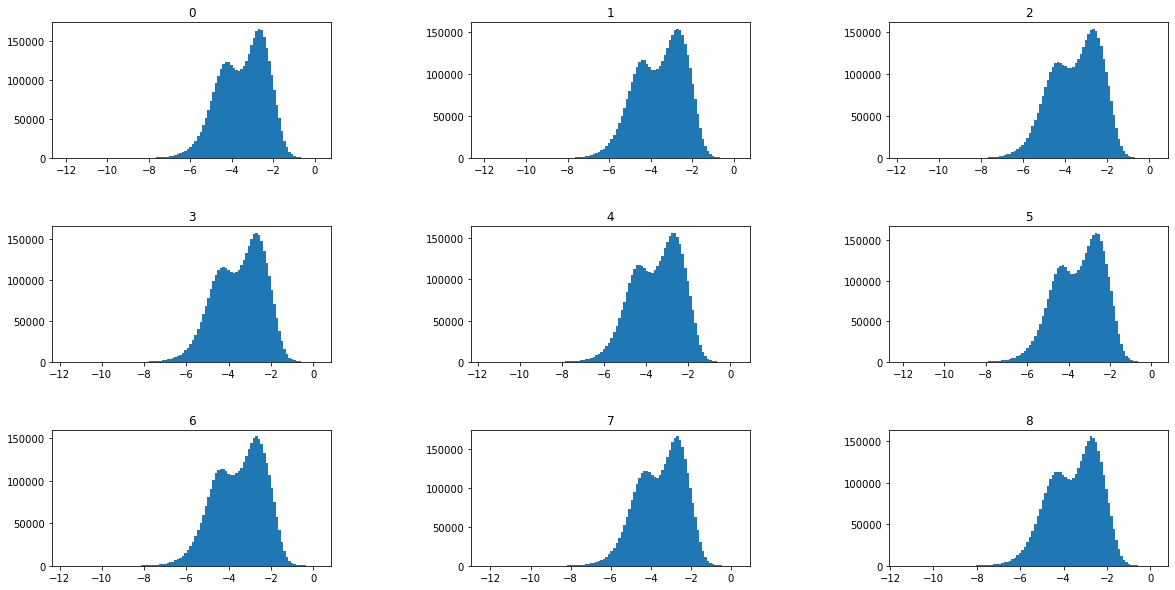

In [168]:
# # create a PyTorch optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# best_loss_angular = 1e10
# warmup_steps = 9

# # make a figure of (warmup_steps//10, 10) subplots
# fig, axs = plt.subplots(warmup_steps//3, 3, figsize=(20, 10))
# # set vertical and horizontal space between subplots
# fig.subplots_adjust(hspace=0.5, wspace=0.5)


# for iter in tqdm(range(warmup_steps)):

        
#     X, y = data_loader.get_xy('train')

#     # evaluate the loss
#     (x, loss), (theta, phi, loss_angular) = model(X, y)
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()
    
#     # # clip the gradients    
#     # if grad_clip:
#     #     torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)
    
    
#     grad_magnitudes = []
#     for param in model.parameters():
#         if param.grad is not None:
#             grad_magnitudes.append(param.grad.abs().detach().cpu().numpy().flatten())
    
    
#     optimizer.step()
    
#     grad_magnitudes = np.abs(np.concatenate(grad_magnitudes))
#     grad_magnitudes = grad_magnitudes[grad_magnitudes > 0]
#     # grad_magnitudes = grad_magnitudes[grad_magnitudes<grad_clip_val]
    
#     # plot plt.hist of grad_magnitudes on the iter-th subplot
#     axs[iter//3, iter%3].hist(np.log10(grad_magnitudes), bins=100)
#     # set title to iter
#     axs[iter//3, iter%3].set_title(iter)
    
    


In [ ]:

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

best_loss_angular = 1e10
total_loss = 0
total_loss_angular = 0


for iter in tqdm(range(max_iters)):



    if iter % gradient_accumulation_steps ==  0 :
        optimizer.zero_grad(set_to_none=True)
        total_loss *= 1 / gradient_accumulation_steps
        total_loss_angular *= 1 / gradient_accumulation_steps
        print(f"step {iter}: train distance loss {total_loss:.4f}, train angular loss {total_loss_angular:.4f} ")
        if LOG_WANDB and iter > 0 and iter % print_each == 0:
            wandb.log({"dis_loc": total_loss,
                        "ang_loc": total_loss_angular
                        })
            # wandb.log({"model": model.state_dict()})
        total_loss = 0.
        total_loss_angular = 0.
    if iter % print_model_each == 0:
        indx = iter // print_model_each
        torch.save(model.state_dict(), f'model_last_overfit_on_batch_{indx}.pth')  
    
    
    
    X, y = data_loader.get_xy('train')
    (x, loss), (theta, phi, loss_angular) = model(X, y)

    total_loss += loss.item()
    total_loss_angular += loss_angular.item()
    loss.backward()
    
    
        
    # if grad_clip:
    #     torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)
    

    # Update the weights every gradient_accumulation_steps batches
    if iter % gradient_accumulation_steps == gradient_accumulation_steps - 1:
        optimizer.step()
    
    

if LOG_WANDB:
    wandb.finish()


In [ ]:
# torch.save(model.state_dict(), 'model.pth')

# Make predictions

In [ ]:
# model.eval()

# batch_size = 64
# predictions = []
# for i in range(0, len(df), batch_size):
#     first_pulse_indices = df["first_pulse_index"][i:i+batch_size].tolist()
#     last_pulse_indices = df["last_pulse_index"][i:i+batch_size].tolist()

#     # preprocessed data as tensors
#     preprocessed_data = [data_loader.get_single_event(first_pulse_index, last_pulse_index, 'eval') for first_pulse_index, last_pulse_index in zip(first_pulse_indices, last_pulse_indices)]

#     # create batch of preprocessed data
#     xyz = torch.stack([data["xyz"] for data in preprocessed_data])
#     time = torch.stack([data["time"] for data in preprocessed_data])
#     charge = torch.stack([data["charge"] for data in preprocessed_data])
    
#     xyz = xyz.to(device)
#     time = time.to(device)
#     charge = charge.to(device)

#     # make predictions
#     with torch.no_grad():
#         (x, _), (theta, phi, _) = model(xyz, time, charge)
    
    
#     theta_predictions = theta.detach().cpu().numpy()
#     phi_predictions = phi.detach().cpu().numpy()
    
#     print(theta_predictions, phi_predictions)
#     pred = np.array([theta_predictions, phi_predictions])
    
#     # predictions.append(pred.T.tolist()[)
    

# print(predictions)
# # df["prediction"] = predictions
# # df["azimuth"] = df["prediction"].apply(lambda x: x[0])
# # df["zenith"] = df["prediction"].apply(lambda x: x[1])

# # event_id,azimuth,zenith
# # df = df[["event_id", "azimuth", "zenith"]]


In [ ]:
# df = df.sort_values(["event_id"])
# df.to_csv('submission.csv', index=False)
# df